In [5]:
from keras.preprocessing import image
from keras.layers import Input, Dense
from keras.models import Model

import matplotlib.pyplot as plt

import numpy as np
import os
import random

%matplotlib inline

In [12]:
DATA_DIR = "./data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")


In [13]:
img = image.load_img('data/train/n01443537/images/n01443537_0.JPEG')

x = image.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [14]:
x.shape

(1, 64, 64, 3)

In [15]:
#Model
from keras.models import Model
from keras.layers import *  

## Dataset creation
The dataset is composed of a random subset of images from all 200 classes.

In [16]:
test_size = 500

def load_dataset(n_images_from_class_test=10, test_size=500):
    X_train = []
    X_test = []
    
    # Create training set
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        
        for img_name_i in c_imgs[0:n_images_from_class_test]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
            
    # Create test set
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:test_size]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)
        
        

    return np.array(X_train), np.array(X_test)
    

In [17]:
X_train_orig, X_test_orig = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [18]:
# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

# TODO Do the same for test images

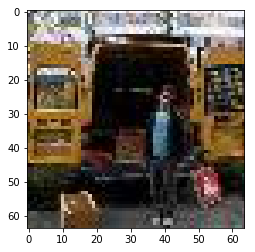

In [19]:
plt.imshow(X_train[11])

## Model

In [20]:
from keras.layers import concatenate, Conv2D
import keras.backend as K

beta = 1.0
def model_loss(y_true, y_pred):
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return c_loss + beta * s_loss

def create_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    # Prep network
    x = Conv2D(3, (7, 7), strides = (1, 1), padding='same', name='conv_prep')(input_S)
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0')(x)
    x = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1')(x)
    x = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2')(x)
    x = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3')(x)
    x = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid4')(x)
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid5')(x)
    
    # TODO Add noise here. Gaussian?
    
    # Reveal network
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0')(output_Cprime)
    # output_Sprime = MaxPooling2D((2, 2), padding='same', name='s_prime')(x)
    
    # Models
    autoencoder = Model(inputs=[input_S, input_C], outputs=concatenate([output_Sprime, output_Cprime]), name = 'AutoEncoderModel')

    # encoder = Model(inputs=[input_S, input_C], outputs=output_Cprime)
    
    # encoded_input = Input(shape=(input_size))
    # decoder_c_layer = autoencoder.get_layer('c_prime')
    # decoder_s_layer = autoencoder.get_layer('s_prime')
    # decoder = Model(inputs=encoded_input, outputs=[decoder_s_layer(encoded_input), decoder_c_layer(encoded_input)])
        
    return autoencoder #, encoder, decoder

In [21]:
autoencoder_model = create_model(input_S.shape[1:])

autoencoder_model.compile(optimizer='adam', loss=model_loss)

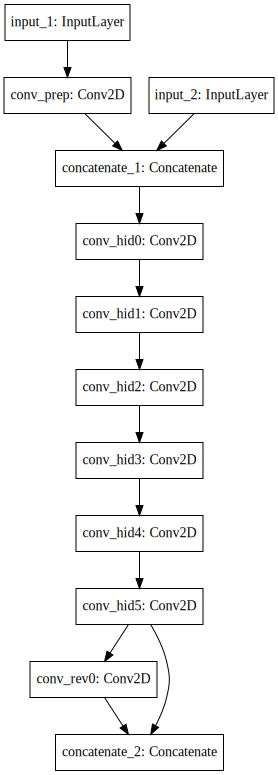

In [34]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder_model).create(prog='dot', format='svg'))

## Training

In [30]:
autoencoder_model.fit([input_S, input_C], np.concatenate((input_S, input_C),axis=3), epochs=1)

Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 80324.3336


## Results

In [32]:
decoded = autoencoder_model.predict([input_S, input_C])

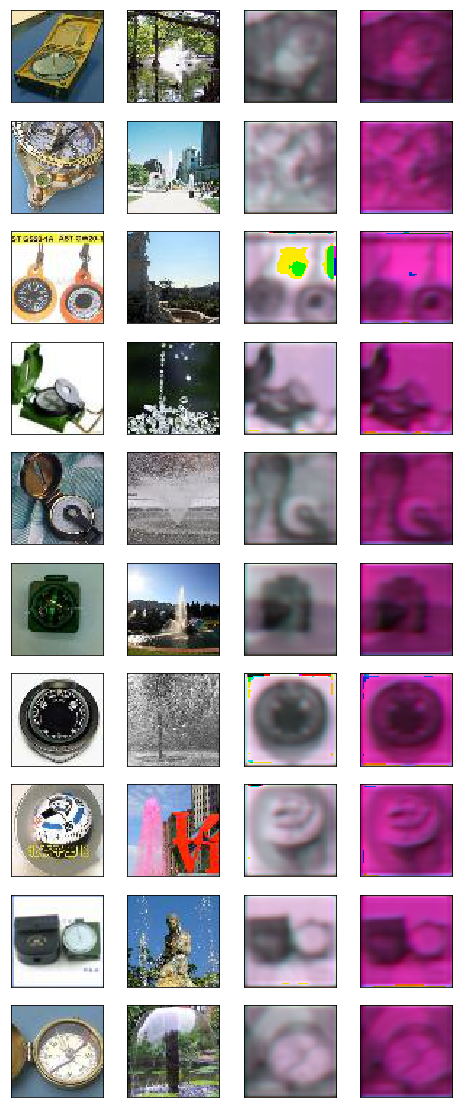

In [33]:
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

n = 10
plt.figure(figsize=(8, 20))
for i in range(0, n):
    ax = plt.subplot(n,4, i * 4 + 1)
    plt.imshow(input_C[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n,4, i * 4 + 2)
    plt.imshow(input_S[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n, 4, i * 4 + 3)
    plt.imshow(decoded_C[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n, 4, i * 4 + 4)
    plt.imshow(decoded_S[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()